In [1]:
# Import libraries
import os
from dotenv import load_dotenv
from IPython.display import display,Image
from typing import TypedDict, Literal
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
import json

In [2]:
# Load environment
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [3]:
# Define LLM
model = ChatOpenAI(model="gpt-4o")

In [4]:
# Define Graph State
class AgentState(TypedDict):
    system_message: str
    question: str
    answer: str
    context: str

In [5]:
def analyze_question(state:AgentState)-> Literal["direct answer", "fetch additional info"]:
    try:
        question = state["question"]
        if not question:
            raise Exception("Ask a question")
        if "ebuilder" in question.lower() or "ecollect" in question.lower():
            return "fetch additional info"
        else:
            return "direct answer"
    except Exception as e:
        state["answer"] = e

In [6]:
def greeting_node(state:AgentState) -> AgentState:
    return { "system_message": "I am a helpful assistant. Ask me anything."}

In [7]:
def fetch_additional_info(state:AgentState) -> AgentState:
    try:
        with open("astha_faq.json", "r", encoding="utf-8") as file:
            faq_data= json.load(file)
        if faq_data:
            context = f"Answer the question only from the following JSON as context\n\n{faq_data}"
        else:
            context = ""
        return {"context": context}
    except Exception as e:
        print(f"Error loading context file: {e}")
        return {"context": ""}
    

In [8]:
def direct_answer(state:AgentState)-> AgentState:
    question = state["question"]
    context = state.get("context", "")
    if context:
        message = context + f"\n\nQuestion:{question}"
    else:
        message = question
    response = model.invoke(message)
    return {"answer": response.content}

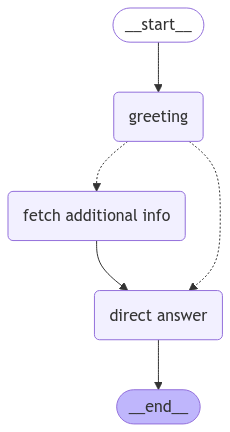

In [9]:
# Define Graph
workflow = StateGraph(AgentState)
# Add nodes
workflow.add_node("greeting", greeting_node)
workflow.add_node("direct answer", direct_answer)
workflow.add_node("fetch additional info", fetch_additional_info)
# Add edges
workflow.add_edge(START,"greeting")
workflow.add_conditional_edges("greeting", analyze_question)
workflow.add_edge("fetch additional info", "direct answer")
workflow.add_edge("direct answer", END)
# Compile graph
graph = workflow.compile()
# Display graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
# Graph invokation
def invoke_graph(question:str):
    output = graph.invoke({"question": question})
    print(f"Question:{output['question']}\n")
    print(f"Answer:{output['answer']}")

In [11]:
invoke_graph("What is Agent in AI?")

Question:What is Agent in AI?

Answer:In the context of artificial intelligence (AI), an "agent" refers to an autonomous entity that perceives its environment through sensors and acts upon that environment through actuators or effectors. The purpose of an AI agent is to achieve specific goals or perform tasks by making decisions based on its perceptions and a given set of rules or learning processes.

There are several types of agents in AI, including:

1. **Simple Reflex Agents**: These agents select actions based on the current percept, ignoring the rest of the percept history. They function by condition-action rules, like "if condition then action."

2. **Model-Based Reflex Agents**: These agents maintain an internal model of the world, which helps them handle partially observable environments by keeping track of the part of the world they cannot see.

3. **Goal-Based Agents**: These agents act to achieve specific goals and can evaluate different courses of action based on how well 

In [12]:
invoke_graph("How to do property booking in ebuilder?")

Question:How to do property booking in ebuilder?

Answer:Go to Marketing Management, select Add Booking, and enter customer and property details. Save the entry to confirm the booking.


In [13]:
invoke_graph("List the financial report in eCollect?")

Question:List the financial report in eCollect?

Answer:eCollect provides detailed financial reports, including account ledgers, bank books, cash books, and statements for comprehensive financial analysis.
